In [1]:
# --- Step 1: Download and unzip dataset from Hugging Face ---
from huggingface_hub import snapshot_download
import os, zipfile

dataset_dir = snapshot_download(
    repo_id="YCAI3/HCI_P2",
    repo_type="dataset",
    local_dir="./HCI_Dataset",
    ignore_patterns=[".gitattributes"]
)
print("Dataset downloaded to:", dataset_dir)

zip_path = os.path.join(dataset_dir, "HCI_Dataset.zip")
extract_dir = os.path.join(dataset_dir, "unzipped")

with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall(extract_dir)

base_path = os.path.join(extract_dir, "HCI_Dataset")
print("✅ Dataset extracted. Example subfolders:", os.listdir(base_path)[:5])


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

README.md:   0%|          | 0.00/971 [00:00<?, ?B/s]

HCI_Dataset.zip:   0%|          | 0.00/1.29G [00:00<?, ?B/s]

Dataset downloaded to: /content/HCI_Dataset
✅ Dataset extracted. Example subfolders: ['50', '10', '198', '53', '195']


In [2]:
# --- Step 2: Collect all image paths and labels ---
from glob import glob
import pandas as pd

image_paths = glob(os.path.join(base_path, "**", "*.jpg"), recursive=True)
print("Total images found:", len(image_paths))

def get_label_from_path(path):
    """Extracts the label text from filename: e.g., 346_Sweetest_76763.jpg -> Sweetest"""
    filename = os.path.basename(path)
    parts = filename.split("_")
    if len(parts) >= 3:
        return parts[1]   # word between underscores
    return None

data = pd.DataFrame({
    "path": image_paths,
    "label": [get_label_from_path(p) for p in image_paths]
})
print(data.sample(5))


Total images found: 609656
                                                     path       label
76910   /content/HCI_Dataset/unzipped/HCI_Dataset/79/3...   cohabited
207021  /content/HCI_Dataset/unzipped/HCI_Dataset/182/...  Ayatollahs
78434   /content/HCI_Dataset/unzipped/HCI_Dataset/191/...         Nat
101131  /content/HCI_Dataset/unzipped/HCI_Dataset/104/...    OCCASION
3832    /content/HCI_Dataset/unzipped/HCI_Dataset/10/6...     Angoras


In [24]:
# --- Step 3: Build character mappings ---
import tensorflow as tf
from tensorflow.keras.layers import StringLookup
import string

# Clean labels and build vocabulary
data["label"] = data["label"].astype(str).str.strip()
# Build exact vocabulary (no empty tokens)
unique_chars = list(string.ascii_letters + string.digits + " ")

# ✅ Define forward and reverse mappings without reserved tokens
char_to_num = StringLookup(vocabulary=unique_chars, mask_token=None, num_oov_indices=0)
num_to_char = StringLookup(vocabulary=unique_chars, mask_token=None, num_oov_indices=0, invert=True)

In [25]:
# --- Step 4: Image + label preprocessing ---
IMG_HEIGHT, IMG_WIDTH = 32, 128

def load_and_preprocess_image(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=1)
    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
    img = img / 255.0
    return img

def encode_label(label):
    label = tf.strings.unicode_split(label, "UTF-8")
    label = char_to_num(label)
    return label

def preprocess(path, label):
    return load_and_preprocess_image(path), encode_label(label)


In [44]:
# --- Step 5: Create and batch dataset ---
paths = data["path"].tolist()
labels = data["label"].tolist()

dataset = tf.data.Dataset.from_tensor_slices((paths, labels))
dataset = dataset.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)

# Split train/val/test
total_size = len(data)
train_size = int(0.8 * total_size)
val_size = int(0.1 * total_size)

train_ds = dataset.take(train_size)
val_ds = dataset.skip(train_size).take(val_size)
test_ds = dataset.skip(train_size + val_size)

# --- ✅ Optimized batching and performance setup ---
BATCH_SIZE = 64
AUTOTUNE = tf.data.AUTOTUNE

train_ds = (
    train_ds
    .cache()                                  # Keep preprocessed samples in memory
    .shuffle(1000)                            # Shuffle before batching
    .padded_batch(BATCH_SIZE, padded_shapes=([64, 256, 1], [None]))
    .prefetch(AUTOTUNE)                       # Prepare next batch while training
)

val_ds = (
    val_ds
    .cache()                                  # Cache validation set too
    .padded_batch(BATCH_SIZE, padded_shapes=([64, 256, 1], [None]))
    .prefetch(AUTOTUNE)
)

test_ds = (
    test_ds
    .cache()
    .padded_batch(BATCH_SIZE, padded_shapes=([64, 256, 1], [None]))
    .prefetch(AUTOTUNE)
)

✅ Optimized datasets ready for fast training.


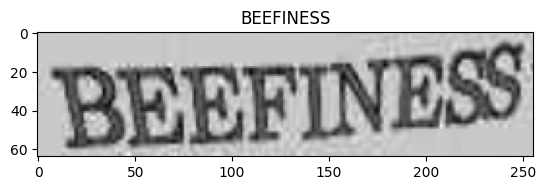

Decoded label: BEEFINESS


In [45]:
# --- Step 6: Visualize a sample image + decoded label ---
import matplotlib.pyplot as plt

for images, labels in train_ds.take(1):
    img = images[8]
    label = labels[8]

    # remove padding zeros before decoding
    valid_chars = tf.gather(label, tf.where(label != 0))
    decoded = tf.strings.reduce_join(num_to_char(valid_chars)).numpy().decode("utf-8")

    plt.imshow(tf.squeeze(img), cmap="gray")
    plt.title(decoded)
    plt.show()
    print("Decoded label:", decoded)


In [47]:
import tensorflow as tf
from tensorflow.keras import layers, Model

def build_crnn(rnn_type="lstm"):
    input_img = layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 1), name="image")

    # --- CNN feature extractor ---
    x = layers.Conv2D(32, 3, activation="relu", padding="same")(input_img)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Conv2D(128, 3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D(2)(x)

    # --- Reshape for RNN ---
    new_shape = (IMG_WIDTH // 8, (IMG_HEIGHT // 8) * 128)
    x = layers.Reshape(new_shape)(x)

    # --- RNN sequence model ---
    if rnn_type == "lstm":
        x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(x)
    else:
        x = layers.Bidirectional(layers.GRU(128, return_sequences=True))(x)

    # --- Dense output ---
    x = layers.Dense(len(unique_chars) + 1, activation="softmax")(x)
    return Model(inputs=input_img, outputs=x, name=f"crnn_{rnn_type}")


In [49]:
def ctc_loss_func(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_len = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_len = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_len = input_len * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_len = label_len * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_len, label_len)
    return loss


In [50]:
for images, labels in train_ds.take(1):
    preds = crnn_lstm(images)
    loss = ctc_loss_func(labels, preds)
    print("CTC loss shape:", loss.shape)


CTC loss shape: (64, 1)


In [52]:
for batch in train_ds.take(1):
    # Access the image using integer index 0
    print("Image batch shape:", batch[0].shape)

Image batch shape: (64, 64, 256, 1)


In [ ]:
crnn_lstm = build_crnn("lstm")
crnn_gru = build_crnn("gru")

optimizers = [
    tf.keras.optimizers.Adam(learning_rate=1e-4),
    tf.keras.optimizers.RMSprop(learning_rate=1e-3)
]

for opt in optimizers:
    crnn_lstm.compile(optimizer=opt, loss=ctc_loss_func)
    crnn_lstm.fit(train_ds, validation_data=val_ds, epochs=10)


Epoch 1/10
1780/7621 ━━━━━━━━━━━━━━━━━━━━ 26:31 273ms/step - loss: 40.5283

In [55]:
import numpy as np

preds = crnn_lstm.predict(test_ds)
decoded = K.ctc_decode(preds, input_length=np.ones(preds.shape[0])*preds.shape[1])[0][0]


InvalidArgumentError: {{function_node __wrapped__IteratorGetNext_output_types_2_device_/job:localhost/replica:0/task:0/device:CPU:0}} Error in user-defined function passed to ParallelMapDatasetV2:52 transformation with iterator: Iterator::Root::Prefetch::PaddedBatchV2::MemoryCacheImpl::FiniteSkip::ParallelMapV2: Input is empty.
	 [[{{node DecodeJpeg}}]] [Op:IteratorGetNext] name: 

In [54]:
decoded_texts = []
for seq in decoded.numpy():
    text = tf.strings.reduce_join(num_to_char(seq)).numpy().decode('utf-8')
    decoded_texts.append(text)
print(decoded_texts[:10])


AttributeError: 'str' object has no attribute 'numpy'